Here we import everything (including the MNIST dataset) and get a subset to train on. We only choose $500$ of the total dataset to train on to simulate limited training data. We randomly permute MNIST, then choose our $500$ in a special way to ensure a uniform distribution among the possible training patterns. This keeps the randomness but ensures that we don't end up with a situation where some numbers are overrepresented and some are underrepresented.

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from numpy import count_nonzero
import numpy as np
import numpy.random as r
import math as m
import matplotlib.pyplot as plt

train_subset = 500
#test_subset = 10000

(train, train_labels), (test, test_labels) = mnist.load_data()
train = train.astype('float32') / 255.
test = test.astype('float32') / 255.
train = train.reshape((len(train), np.prod(train.shape[1:])))
test = test.reshape((len(test), np.prod(test.shape[1:])))

permuted = r.permutation(list(zip(train, train_labels)))

train = np.ndarray(shape=(0, 784))
labels = np.ndarray(shape=0)

num_of_each = train_subset / 10
running_total = [0] * 10

for i in range(0, len(permuted)):
    if running_total[permuted[i][1]] < num_of_each:
        running_total[permuted[i][1]] += 1
        train = np.append(train, [permuted[i][0]], axis=0)
        labels = np.append(labels, [permuted[i][1]], axis=0)

#train = np.array(list(map(lambda i: i[0], permuted)))
#labels = np.array(list(map(lambda i: i[1], permuted)))

train_labels_onehot = to_categorical(labels)
test_labels_onehot = to_categorical(test_labels)

print(train.shape)
print(test.shape)
print(train_labels_onehot.shape)
print(test_labels_onehot.shape)

2022-11-29 22:21:59.158246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/oneapi/vpl/2022.2.5/lib:/opt/intel/oneapi/tbb/2021.7.1/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.7.1//libfabric/lib:/opt/intel/oneapi/mpi/2021.7.1//lib/release:/opt/intel/oneapi/mpi/2021.7.1//lib:/opt/intel/oneapi/mkl/2022.2.1/lib/intel64:/opt/intel/oneapi/itac/2021.7.1/slib:/opt/intel/oneapi/ipp/2021.6.2/lib/intel64:/opt/intel/oneapi/ippcp/2021.6.2/lib/intel64:/opt/intel/oneapi/ipp/2021.6.2/lib/intel64:/opt/intel/oneapi/dnnl/2022.2.1/cpu_dpcpp_gpu_dpcpp/lib:/opt/intel/oneapi/debugger/2021.7.1/gdb/intel64/lib:/opt/intel/oneapi/debugger/2021.7.1/libipt/intel64/lib:/opt/intel/oneapi/debugger/2021.7.1/dep/lib:/opt/intel/oneapi/dal/2021.7.1/lib/intel64:/opt/intel/oneapi/compiler/2022.2.1/linux/lib:/opt/intel/oneapi/compiler/

(500, 784)
(10000, 784)
(500, 10)
(10000, 10)


Here we create a training function that will train our dense and sparse networks. **We use the same training function on both!** Using the same kernel on the sparse network will incur "fill-in," i.e., we will add important connections back to the network.

In [2]:
def train_net(W, lam, input_count, input_neurons, train, labels, nums):
    sparsity = np.ndarray(0)
    for p in range(input_count):
        for i in range(input_neurons):
            for j in range(nums):
                W[i, j] += lam * train[p, i] * labels[p, j]
        W = np.apply_along_axis(lambda line: line / np.linalg.norm(line), 1, W)
        if p % (input_count / 10) == 0:
            print(str(p / input_count * 100) + "% done training")  
        sparsity_step = (1.0 - (count_nonzero(W) / float(W.size))) * 100
        sparsity = np.append(sparsity, [sparsity_step])
    print("Training done!")
    return (W, sparsity)

Plotting function to plot sparsity.

In [3]:
def plot_sparsity(steps, sparsity):
    ep_titles = list(range(1, steps + 1))
    ep_ticks = [1] + list(range(50, steps + 1, 50))
    
    plt.plot(ep_titles, sparsity, label="sparsity")
    plt.legend()
    plt.xlabel("Training Step")
    plt.ylabel("Sparsity")
    plt.suptitle("Sparsity as a Function of Training Steps")
    plt.xticks(ep_ticks)
    plt.show()

Here we train the dense network... we see that it consistently has $0\%$ sparsity over the duration of training.

[[-0.56606568  0.38097961  0.34440709 ... -0.30568146  0.26186582
  -0.17861279]
 [-0.3241042   0.02933942  0.43042676 ...  0.01797648 -0.32138508
   0.1477185 ]
 [ 0.10660849 -0.30958277  0.00511151 ... -0.63868106 -0.24605343
   0.22796005]
 ...
 [ 0.42029301 -0.12474025  0.05148255 ...  0.2587053   0.17922038
   0.28241066]
 [-0.07659394  0.23491131  0.12401021 ... -0.10223391  0.08270774
  -0.32328115]
 [ 0.1988376   0.5329454  -0.13926027 ... -0.35562569  0.1903498
   0.56418558]]
(784, 10)
0.0% done training
10.0% done training
20.0% done training
30.0% done training
40.0% done training
50.0% done training
60.0% done training
70.0% done training
80.0% done training
90.0% done training
Training done!


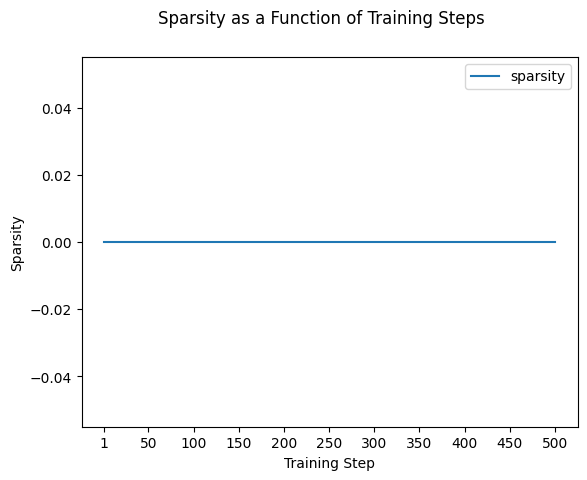

In [4]:
nums = 10
input_count = train.shape[0]
input_neurons = train.shape[1]

Wd = r.randn(train.shape[1], nums)
Wd = np.apply_along_axis(lambda line: line / np.linalg.norm(line), 1, Wd)

print(Wd)
print(Wd.shape)

lam = 0.01

(Wd, sparsity) = train_net(Wd, lam, input_count, input_neurons, train, train_labels_onehot, nums)

plot_sparsity(input_count, sparsity)

And here we train the sparse network with a sparsity of $90\%$ to start out. The training will incur some fill-in, and we can see that shown in the graph.

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(784, 10)
0.0% done training
10.0% done training
20.0% done training
30.0% done training
40.0% done training
50.0% done training
60.0% done training
70.0% done training
80.0% done training
90.0% done training
Training done!


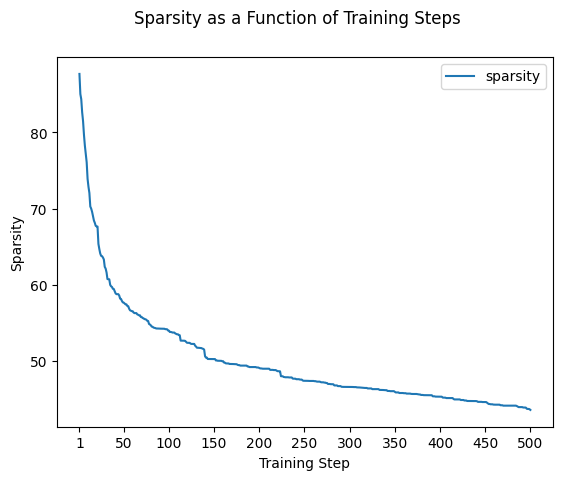

In [5]:
Ws = np.zeros((train.shape[1], nums))
for i in range(input_neurons):
    Ws[i, i % nums] = 1
Ws = np.apply_along_axis(lambda line: line / np.linalg.norm(line), 1, Ws)

print(Ws)
print(Ws.shape)

lam = 0.01

(Ws, sparsity) = train_net(Ws, lam, input_count, input_neurons, train, train_labels_onehot, nums)

plot_sparsity(input_count, sparsity)

Here we do a random assignment of neuron connections. I tried the primitive way of randomly setting each input neuron's assigned output neuron, but it gave really bad results. Here we ensure that each output neuron has the same number of input neurons going into it. This helps accuracy, but as we'll see, not enough to beat the earlier result.

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
(784, 10)
0.0% done training
10.0% done training
20.0% done training
30.0% done training
40.0% done training
50.0% done training
60.0% done training
70.0% done training
80.0% done training
90.0% done training
Training done!


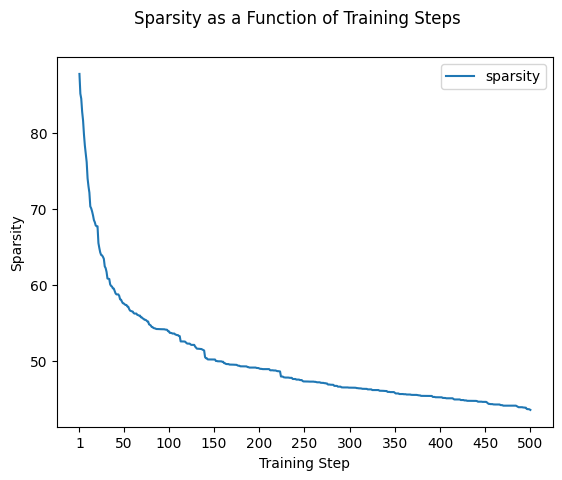

In [6]:
Wsr = np.zeros((train.shape[1], nums))
for i in range(input_neurons):
    #Wsr[i, r.randint(0, 10)] = 1
    Wsr[i, i % nums] = 1
Wsr = r.permutation(Wsr)
Wsr = np.apply_along_axis(lambda line: line / np.linalg.norm(line), 1, Wsr)

print(Wsr)
print(Wsr.shape)

lam = 0.01

(Wsr, sparsity) = train_net(Wsr, lam, input_count, input_neurons, train, train_labels_onehot, nums)

plot_sparsity(input_count, sparsity)

And here we compare the accuracy. And... surprise! The sparse network trains much better! Still... not good, but better! In my tests, the "worst" improvement I saw was $8\%$ and the "best" improvement I saw was a whopping $29\%$! I've included that really awesome run.

In [7]:
def get_max(arr):
    return np.argmax(arr)

def run_network(W, dataset):
    WT = np.transpose(W)
    return get_max(np.matmul(WT, dataset))

correct_dense = 0

for i in range(test.shape[0]):
    result = run_network(Wd, test[i])
    if (result == test_labels[i]).all():
        correct_dense += 1

correct_sparse = 0
correct_sparser = 0

for i in range(test.shape[0]):
    result = run_network(Ws, test[i])
    if (result == test_labels[i]).all():
        correct_sparse += 1     

for i in range(test.shape[0]):
    result = run_network(Wsr, test[i])
    if (result == test_labels[i]).all():
        correct_sparser += 1

accuracy_dense = correct_dense / test.shape[0] * 100
print("Dense accuracy:", np.floor(accuracy_dense), "%")
accuracy_sparse = correct_sparse / test.shape[0] * 100
print("Sparse accuracy:", np.floor(accuracy_sparse), "%")
accuracy_sparser = correct_sparser / test.shape[0] * 100
print("Sparse_random accuracy:", np.floor(accuracy_sparser), "%")

sparsity = (1.0 - (count_nonzero(Ws) / float(Ws.size))) * 100    
print()
print("Sparse network trains better:", "yes" if accuracy_sparse > accuracy_dense else "no")
print("Sparsity:", sparsity, "%")
needed_sparsity = (1.0 - (((Ws.shape[0] * (Ws.shape[1] - 1) - 1) / 2) / float(Ws.size))) * 100
print("Would need sparsity of", needed_sparsity, "% to save space.")
print("CSR matrix would save space:", "yes" if sparsity > needed_sparsity else "no")

sparsityr = (1.0 - (count_nonzero(Wsr) / float(Wsr.size))) * 100     
print()
print("Sparse_random network trains better:", "yes" if accuracy_sparser > accuracy_dense else "no")
print("Sparsity:", sparsityr, "%")
print("Would need sparsity of", needed_sparsity, "% to save space.")
print("CSR matrix would save space:", "yes" if sparsityr > needed_sparsity else "no")

Dense accuracy: 29.0 %
Sparse accuracy: 58.0 %
Sparse_random accuracy: 49.0 %

Sparse network trains better: yes
Sparsity: 43.57142857142857 %
Would need sparsity of 55.0063775510204 % to save space.
CSR matrix would save space: no

Sparse_random network trains better: yes
Sparsity: 43.5204081632653 %
Would need sparsity of 55.0063775510204 % to save space.
CSR matrix would save space: no
